# 用注意力机制实现中英文互译

## 导入所需模块

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import jieba
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname='C:\font\simhei.ttf')
#from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']  #中文显示问题

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 数据预处理

数据预处理的主要步骤包括：
1. 读取txt文件，并按行分割，再把每一行分割成一个pair(Eng,Chinese)
2. 过滤并处理文本信息
3. 从每个pair中，制作出中文词典和英文词典
4. 构建训练集

In [2]:
#每个pair中，制作出中文和英文词典
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS单词总量 初始化包含 SOS and EOS
    #处理英文句子
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    #处理中文句子
    def addSentence_cn(self, sentence):
        for word in list(jieba.cut(sentence)):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# 过滤并处理文本信息

#为了便于数据处理，把Unicode字符串转换为ASCII编码
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 对英文转换为小写，去空格及非字母符号等处理

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
        

In [4]:
#读数据，这里标签lang1,lang2作为参数，可提高模块通用性，可以进行多种语言的互译，只需修改数据问价及这两个参数即可
def readLangs(lang1,lang2,reverse=False):
    print("Reading lines...")
    #读文件，然后分成行
    lines=open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    #把行分成句子对，并进行规范化
    pairs=[[normalizeString(s) for s in l.split('\t')] for l in lines]
    #判断是否需要转换语句的次序，如[英文，中文]转换为[中文，英文]次序
    if reverse:
        pairs=[list(reversed(p)) for p in pairs]
        input_lang=Lang(lang2)
        output_lang=Lang(lang1)
    else:
        input_lang=Lang(lang1)
        output_lang=Lang(lang2)
    return input_lang,output_lang,pairs

In [5]:
#为便于训练，这里选择部分数据
MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
#把以上数据预处理函数，放在一起，实现对数据的预处理
def prepareData(lang1,lang2,reverse=False):
    input_lang,output_lang,pairs=readLangs(lang1,lang2,reverse)
    
    print('Read %s sentence pairs'% len(pairs))
    pairs=filterPairs(pairs)
    print('Trimmed to %s sentence pairs' % len(pairs))
    print('Counting words...')
    for pair in pairs:
        input_lang.addSentence_cn(pair[0])
        output_lang.addSentence(pair[1])
    print('Counted words:')
    print(input_lang.name,input_lang.n_words)
    print(output_lang.name,output_lang.n_words)
    return input_lang, output_lang, pairs

In [7]:
#运行预处理函数
input_lang,output_lang,pairs=prepareData('eng','cmn',True)
print(random.choice(pairs))

Reading lines...
Read 21007 sentence pairs
Trimmed to 640 sentence pairs
Counting words...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DOT-1\AppData\Local\Temp\jieba.cache
Loading model cost 0.766 seconds.
Prefix dict has been built successfully.


Counted words:
cmn 1063
eng 808
['他全神贯注。', 'he is giving his whole attention to that .']


In [8]:
pairs[:3]

[['我冷。', 'i am cold .'], ['我沒事。', 'i am okay .'], ['我生病了。', 'i am sick .']]

## 构建模型

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def indexesFromSentence_cn(lang, sentence):
    return [lang.word2index[word] for word in list(jieba.cut(sentence))]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence_cn(lang, sentence):
    indexes = indexesFromSentence_cn(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence_cn(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## 训练模型

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence_cn(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

5m 39s (- 79m 15s) (5000 6%) 2.6421
11m 3s (- 71m 50s) (10000 13%) 1.1196
16m 43s (- 66m 53s) (15000 20%) 0.2051
22m 3s (- 60m 40s) (20000 26%) 0.0443
27m 23s (- 54m 46s) (25000 33%) 0.0281
32m 43s (- 49m 5s) (30000 40%) 0.0218
38m 4s (- 43m 30s) (35000 46%) 0.0186
43m 25s (- 37m 59s) (40000 53%) 0.0144
48m 55s (- 32m 36s) (45000 60%) 0.0136
54m 26s (- 27m 13s) (50000 66%) 0.0147
60m 7s (- 21m 51s) (55000 73%) 0.0129
65m 41s (- 16m 25s) (60000 80%) 0.0143
71m 18s (- 10m 58s) (65000 86%) 0.0130
76m 49s (- 5m 29s) (70000 93%) 0.0105
82m 14s (- 0m 0s) (75000 100%) 0.0124


<Figure size 432x288 with 0 Axes>

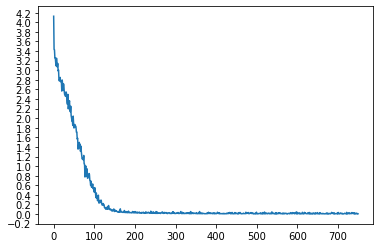

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

## 随机采样，对模型进行测试

In [21]:
evaluateRandomly(encoder1, attn_decoder1)

> 您是學生。
= you are a student .
< you are a student . <EOS>

> 他這個人很難相處。
= he is difficult to get along with .
< he is difficult to get along with . <EOS>

> 我开始记起来了。
= i am beginning to remember it .
< i am beginning to remember it . <EOS>

> 他们在互相交谈。
= they are talking with each other .
< they are talking with each other . <EOS>

> 她们嫉妒我们的成功。
= they are jealous of our success .
< they are jealous of our success . <EOS>

> 我在叠我的连衣裙。
= i am folding my dress .
< i am folding my dress . <EOS>

> 他壞透了。
= he is rotten to the core .
< he is rotten to the core . <EOS>

> 我很高興有她的陪伴。
= i am glad to have her company .
< i am glad to have her company . <EOS>

> 他们正努力降低成本。
= they are trying to keep costs down .
< they are trying to keep costs down . <EOS>

> 我非常，非常抱歉。
= i am very, very sorry .
< i am very, very sorry . <EOS>



In [22]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [23]:
def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 可视化注意力

In [29]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(jieba.cut(input_sentence)) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

input = 我很高興有她的陪伴。
output = i am glad to have her company . <EOS>


<Figure size 432x288 with 0 Axes>

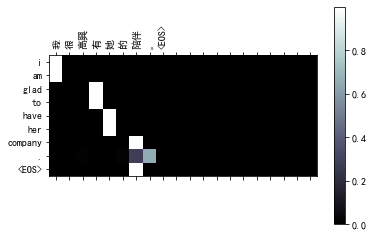

input = 他们正努力降低成本。
output = they are trying to keep costs down . <EOS>


<Figure size 432x288 with 0 Axes>

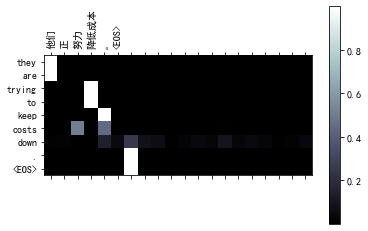

In [30]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("我很高興有她的陪伴。")

evaluateAndShowAttention("他们正努力降低成本。")
